In [1]:
# import packages
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statistics
import warnings
import numpy as np, scipy.stats as st
from pandas.core.common import SettingWithCopyWarning

In [2]:
# deaths
state = "Colorado"
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
stateTimeSeries = pd.read_csv(url, error_bad_lines=False)
# COVID Data
numCounty = 64
deathData = stateTimeSeries.loc[stateTimeSeries['Province_State'] == state]
deathData = deathData.sort_values(by=['FIPS'])
labelsData = deathData[['FIPS', 'Admin2']][:-2]
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
deathData['FIPS'] = deathData['FIPS'].astype(int)
# gets fips columns and then the days of deaths
countyTime = deathData.iloc[:, [4] + list (range(12, len(deathData.columns)))][:-2]
# gets total number of deaths
covidCounty = countyTime['9/6/20'].values.astype(int)
# Dictionary of the county names and FIPS
labelsDict = dict()
for ind, row in labelsData.iterrows():
    labelsDict [int(row['FIPS'])] = row['Admin2']
labels = list(labelsDict.values())

# Cause-Based Results

In [3]:
# Data until Week Ending on Sept 6th
timeCause = dict()
raw = pd.read_csv('csv_data/co_deaths_causes.csv')
# List of Races and Ethnicities in Dataset used Later
raceList = ['American Indian/Alaska Native', 'Asian/Pacific Islander', 'Black/African American', 'White']
hispList = ['Hispanic', 'Non-Hispanic']
raw = raw[raw.dwk != 'Annual total']
raw['dwk'] = raw['dwk'].astype(int)

# Correct Year
raw = raw[raw['year'] == 2020]
# Correct time range
raw = raw[raw['dwk'].isin(list(range(9, 35)))]
# Data for both sexes, all ages, races, and ethnicities
raw = raw.loc[raw['sexgr'] == 'Total - Both Sexes']
raw = raw.loc[raw['agegr'] == 'All Ages']
raw = raw.loc[raw['racegr'] == 'All races']
raw = raw.loc[raw['hispgr'] == 'All ethnicities']
# Different Causes of Death
titles = raw.columns.values[7:]
cause2020 = dict()
# Deaths by cause of Death in 2020
for title in titles:
    cause2020[title] = raw.groupby('fips')[title].sum().values.astype(int)[1:]

In [4]:
# Cause of Death in the baseline years (2015-2019)
baselineCause = dict()
first = True
years = [2015, 2016, 2017, 2018, 2019]
for year in years:
    # Reading in data for each year
    raw = pd.read_csv('csv_data/co_deaths_causes.csv')
    raw = raw[raw.dwk != 'Annual total']
    raw['dwk'] = raw['dwk'].astype(int)
    raw = raw[raw['year'] == year]
    raw = raw[raw['dwk'].isin(list(range(9, 35)))]
    
    # Data for both sexes, all ages, races, and ethnicities
    raw = raw.loc[raw['sexgr'] == 'Total - Both Sexes']
    raw = raw.loc[raw['agegr'] == 'All Ages']
    raw = raw.loc[raw['racegr'] == 'All races']
    raw = raw.loc[raw['hispgr'] == 'All ethnicities']
    titles = raw.columns.values[7:]
    
    # Adding the deaths in each year to an array containing deaths over the years for a specific type of death
    if first:
        for title in titles:
            baselineCause[title] = raw.groupby('fips')[title].sum().values.astype(int)[1:]
            timeCause [title] = [sum(raw.groupby('fips')[title].sum().values.astype(int)[1:])]
        first = False
    else:
        for title in titles:
            baselineCause[title] += raw.groupby('fips')[title].sum().values.astype(int) [1:]
            timeCause [title].append(sum(raw.groupby('fips')[title].sum().values.astype(int)[1:]))

# Average Deaths for 2015-2019
for key in baselineCause:
    baselineCause[key] = np.array(baselineCause[key])/len(years)

# Adding 2020 deaths to the previous years
for key in timeCause:    
    timeCause[key].append(sum(cause2020[key]))

In [5]:
# Population for each county
numCounty = 64
numYears = 6
path = 'csv_data/CountyRankings.xls'
popDf = pd.read_excel(path, index_col = None)
popDf = popDf.iloc[:, 6:12]
pop = popDf['July 2017'].values.astype(float) / 100000.
popArr = np.zeros((numYears, numCounty))
yearN = list(popDf.columns)
for i, year in enumerate(yearN):
    popArr[i, :] = popDf[year].values.astype(float)
popArr = popArr / 100000.

In [6]:
sumDeaths = 0
for key in timeCause:
    if key != 'd':
        sumDeaths += timeCause[key][5]

print('Percent of Deaths we have Cause of Deaths for:' + str(sumDeaths/timeCause['d'][5]))

Percent of Deaths we have Cause of Deaths for:0.7765707444685851


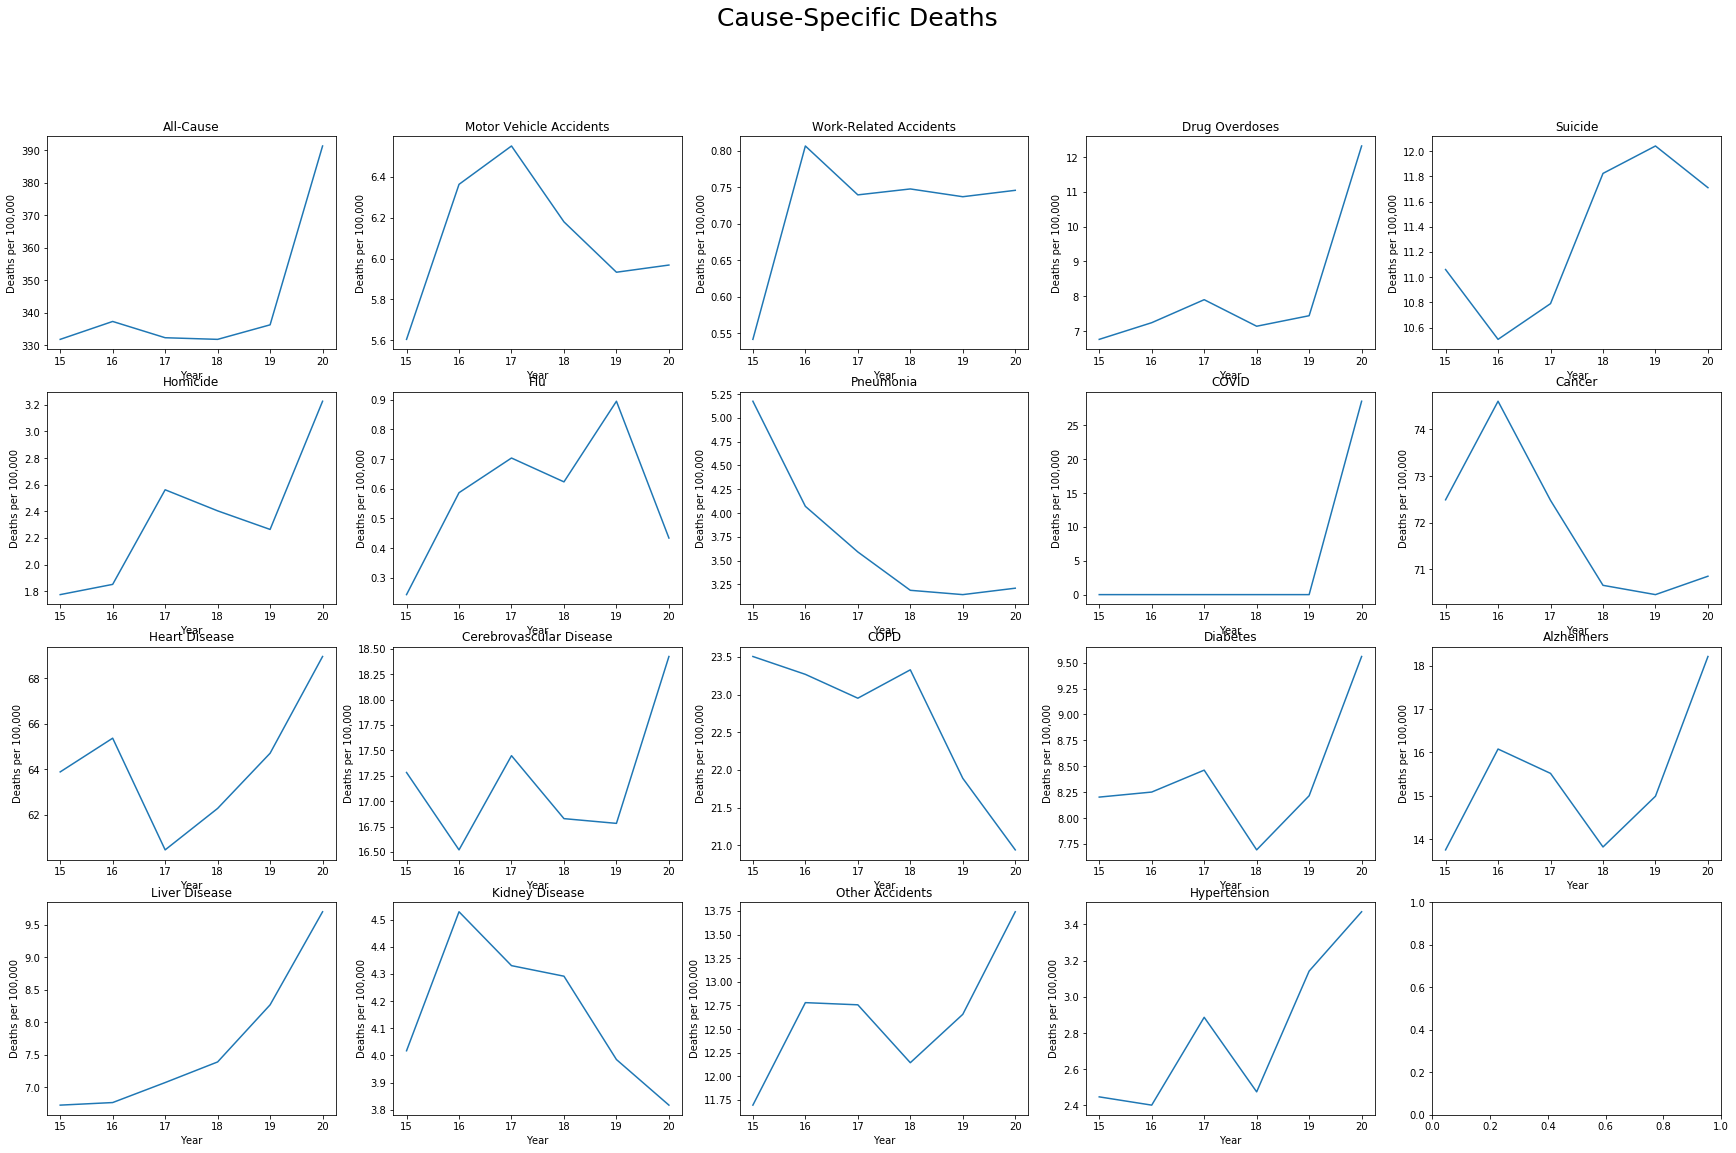

In [7]:
# Titles for the Causes of death
titles = ['All-Cause', 'Motor Vehicle Accidents', 'Work-Related Accidents', 'Drug Overdoses', 'Suicide', 'Homicide', 
         'Flu', 'Pneumonia', 'COVID', 'Cancer', 'Heart Disease', 'Cerebrovascular Disease', 'COPD', 'Diabetes', 
          'Alzheimers', 'Liver Disease', 'Kidney Disease', 'Other Accidents', 'Hypertension']

# Excess Deaths for each cause of death
timeCausePop = dict()
for key in timeCause:
    timeCausePop[key] = timeCause[key] / np.sum(popArr, axis = 1)

# Difference in Deaths from the Previous Year
timeCauseDiffPop = dict()
for key in timeCause:
    temp = []
    for i, el in enumerate(timeCausePop[key]):
        if i != 0:
            temp.append(el-timeCausePop[key][i - 1])
    timeCauseDiffPop[key] = temp

# Difference in Deaths from the Previous Year Normalized for the Population
timeCausePerPop = dict()
for key in timeCausePop:
    if key != 'covid':
        temp = []
        for i, el in enumerate(timeCauseDiffPop[key]):
            temp.append((float(el)/float(timeCausePop[key][i])) * 100)
    timeCausePerPop[key] = temp
    
# Set of Plots for the various couases od deaths 
years2 = ['15', '16', '17', '18', '19', '20']
fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize = (30,18))
index = 0
for row in ax:
    for col in row:
        if index <= 18:
            col.plot(years2, timeCausePop[list(timeCausePop.keys())[index]])
            col.set_title(titles[index])
            col.set(xlabel="Year", ylabel='Deaths per 100,000')
            # 'Current Year - Previous Year Deaths per 100,000'
            index += 1
fig.suptitle("Cause-Specific Deaths", fontsize = 25)
plt.show(fig)

# Remove COVID and all-cause deaths from any of the further analysis
timeCause.pop('covid')
timeCause.pop('d');
baselineCause.pop('covid')
baselineCause.pop('d')
cause2020.pop('covid')
cause2020.pop('d');

In [8]:
# County Level to State Level Deaths
sumCause2020 = dict()
for key in cause2020:
    sumCause2020[key] = sum(cause2020[key])
    
sumBaselineCause = dict()
for key in baselineCause:
    sumBaselineCause[key] = sum(baselineCause[key])
    
# Excess Deaths Calculation for each county and cause
excessDeathCause = dict()
for key in cause2020:
    excessDeathCause[key] = cause2020[key]-baselineCause[key]

#  Aggregation to the County Level
sumExcessDeathCause = dict()
for key in excessDeathCause:
    sumExcessDeathCause[key] = sum(excessDeathCause[key])

# Population Normalized State-Level Cause Based Deaths
sumExcessDeathCausePop = dict()
for key in sumExcessDeathCause:
    sumExcessDeathCausePop[key] = sumExcessDeathCause[key] / sum(pop)

# Excess Deaths by Cause for each County
excessDeathCausePop = dict()   
for key in excessDeathCause:
    excessDeathCausePop[key] = excessDeathCause[key] / pop
    
# County Titles Appended so that we can identify cause-specific deaths in each county
labelExcessDeathCausePop = dict() 
for key in excessDeathCausePop:
     labelExcessDeathCausePop [key] = dict(zip(labels, excessDeathCausePop[key]))

# Titles without All-Cause Deaths and COVID Deaths
titles2 = ['Motor Vehicle Accidents', 'Work-Related Accidents', 'Drug Overdoses', 'Suicide', 'Homicide', 
 'Flu', 'Pneumonia', 'Cancer', 'Heart Disease', 'Cerebrovascular Disease', 'COPD', 'Diabetes', 
  'Alzheimers', 'Liver Disease', 'Kidney Disease', 'Other Accidents', 'Hypertension']

# Titles Indicating Chronic vs Acute Illness
titles2Star = ['Motor Vehicle Accidents*', 'Work-Related Accidents*', 'Drug Overdoses*', 'Suicide*', 'Homicide*', 
         'Flu*', 'Pneumonia*', 'Cancer', 'Heart Disease', 'Cerebrovascular Disease', 'COPD', 'Diabetes', 
          'Alzheimers', 'Liver Disease', 'Kidney Disease', 'Other Accidents*', 'Hypertension']

# For the Stacked bar plot representing the makeup of diseases in 2020 vs 2015-2019
labeledSumCause2020 = dict()
labeledSumBaselineCause = dict()
sum2020 = sum(sumCause2020.values())
sumBaseline = sum(sumBaselineCause.values())
for i, key in enumerate(sumCause2020):
    labeledSumCause2020[titles2[i]] = (sumCause2020[key] / sum2020) * 100
    labeledSumBaselineCause[titles2[i]] = (sumBaselineCause[key] / sumBaseline) * 100

In [9]:
# 95% Confidence Interval for the baseline based on the deaths from 2015-2019
rangeT = dict()
for cause in timeCause:
    selectPlace = timeCause[cause][0:5]
    baselineInt = st.t.interval(0.95, len(selectPlace)-1, loc=np.mean(selectPlace), scale=st.sem(selectPlace))
    rangeT[cause] = baselineInt

errorT = dict()
for item in rangeT:
    errorT[item] = (rangeT[item][1]-rangeT[item][0])
errorTPop = list(errorT.values())/(sum(pop)*2)

errorDir = dict()
for item in rangeT:
    errorDir[item] = [timeCause[item][5]/rangeT[item][0], timeCause[item][5]/rangeT[item][1]]
errorDir = list(errorDir.values())

In [10]:
# 95% Confidence Interval for the ratios
rangeT = dict()
for cause in timeCause:
    selectPlace = timeCause[cause][0:5]
    baselineInt = st.t.interval(0.95, len(selectPlace)-1, loc= 1./ float(np.mean(selectPlace)), 
                                scale=st.sem(selectPlace) * (1./float(np.mean(selectPlace)))**2)
    rangeT[cause] = ([timeCause[cause][5] * baselineInt[0], timeCause[cause][5] * baselineInt[1]])

errorT = dict()
for item in rangeT:
    errorT[item] = ((rangeT[item][1]-rangeT[item][0])/2)

In [11]:
# Ratio of Deaths in 2020 to the average in the 2015-2019
ratioDeaths = dict()
for i, key in enumerate(timeCause):
    middle = timeCause[key][5]/np.mean(timeCause[key][0:5])
    ratioDeaths[key] = (middle, errorT[key])

ratioDeaths = dict(zip(titles2Star,ratioDeaths.values()))
sorted_multiplier = sorted(ratioDeaths.items(), key=lambda kv: kv[1][0])
dict_ratioDeaths = dict() 
for key,value in sorted_multiplier: 
    dict_ratioDeaths.setdefault(key, value)
sorted_multiplier = dict_ratioDeaths.copy()

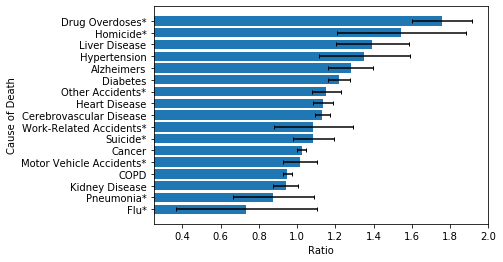

In [12]:
# Plot of Ratios
y_pos = np.arange(len(sorted_multiplier))
plt.barh(y_pos, [i[0] for i in list(sorted_multiplier.values())], align='center')
plt.yticks(y_pos, list(sorted_multiplier.keys()))
plt.xlabel('Ratio')
plt.ylabel('Cause of Death')
plt.errorbar([i[0] for i in list(sorted_multiplier.values())], y_pos, 
             xerr=np.array([i[1] for i in list(sorted_multiplier.values())]).T, ls='none', 
             ecolor = 'black', capsize = 2)
plt.xlim((0.25, 2.0))
plt.savefig('COD Ratio.png', bbox_inches='tight', dpi = 300)
plt.show()

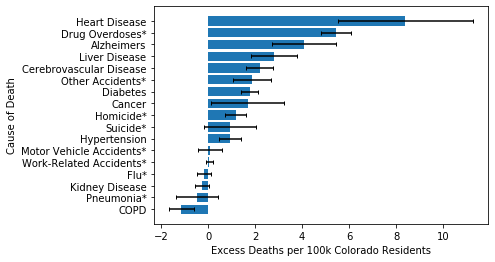

In [13]:
# Sorting the Excess Deaths
labeledSumExcessDeathCausePop = dict()
for i, key in enumerate(sumExcessDeathCausePop):
    labeledSumExcessDeathCausePop[titles2Star[i]] = (sumExcessDeathCausePop[key], errorTPop[i])
    
sorted_labeledSumExcessDeathCausePop = sorted(labeledSumExcessDeathCausePop.items(), key=lambda kv: kv[1][0])
dict_sorted_DeathCause = dict() 
for key,value in sorted_labeledSumExcessDeathCausePop: 
    dict_sorted_DeathCause.setdefault(key, value)
sorted_labeledSumExcessDeathCausePop = dict_sorted_DeathCause.copy()

# Excess Deaths by Cause Death
y_pos = np.arange(len(sorted_labeledSumExcessDeathCausePop))
plt.barh(y_pos, [i[0] for i in list(sorted_labeledSumExcessDeathCausePop.values())], align='center')
plt.errorbar([i[0] for i in list(sorted_labeledSumExcessDeathCausePop.values())], y_pos,
             xerr = [i[1] for i in list(sorted_labeledSumExcessDeathCausePop.values())], ls='none', ecolor = 'black', capsize = 2)
plt.yticks(y_pos, list(sorted_labeledSumExcessDeathCausePop.keys()))
plt.xlabel('Excess Deaths per 100k Colorado Residents')
plt.ylabel('Cause of Death')
plt.savefig('COD ED.png', bbox_inches='tight', dpi = 300)
plt.show()

In [14]:
# Creates a Dataframe with Population Adjusted Excess Deaths
Struct = pd.DataFrame.from_dict(sorted_labeledSumExcessDeathCausePop, orient='index', columns=['Excess Deaths', 'Error'])

writer = pd.ExcelWriter('Cause_Excess_Error.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Struct.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

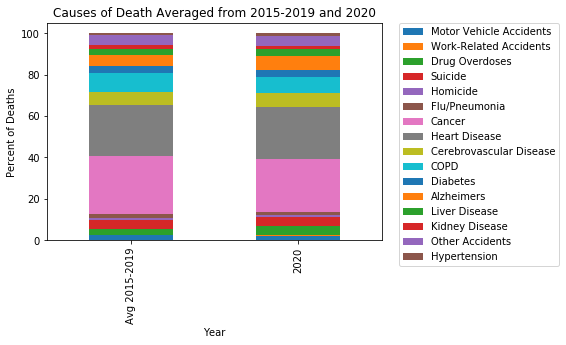

In [15]:
# Stacked Bar Plot by Percentage of Type of Death
StructGraph = pd.DataFrame.from_dict(labeledSumBaselineCause, orient='index', columns=['Avg 2015-2019'])
StructGraph.insert(1, column = '2020', value = labeledSumCause2020.values())
StructGraph = StructGraph.transpose()
StructGraph.insert(loc = 5, column = 'Flu/Pneumonia', value = StructGraph['Flu'] + StructGraph['Pneumonia'])
StructGraph = StructGraph.drop(['Flu', 'Pneumonia'], 1)
axis = StructGraph[StructGraph.columns].plot(kind="bar", stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Causes of Death Averaged from 2015-2019 and 2020')
plt.xlabel('Year')
plt.ylabel('Percent of Deaths')
fig = axis.get_figure()

In [16]:
# Save Excess Deaths by Cause
titles2 = ['Motor Vehicle Accidents', 'Work-Related Accidents', 'Drug Overdoses', 'Suicide', 'Homicide', 
 'Flu', 'Pneumonia', 'Cancer', 'Heart Disease', 'Cerebrovascular Disease', 'COPD', 'Diabetes', 
  'Alzheimers', 'Liver Disease', 'Kidney Disease', 'Other Accidents', 'Hypertension']

# Creates a Dataframe with Cause-Specific Excess Deaths
Struct = pd.DataFrame.from_dict(sumCause2020, orient='index', columns=['2020 deaths'])
Struct.insert(1, column = 'Avg 2015-2019', value = sumBaselineCause.values())
Struct.insert(2, column = 'Full Titles', value = titles2)

writer = pd.ExcelWriter('Cause_Specific_Deaths.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Struct.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [17]:
import numpy as np, scipy.stats as st
selectCause = timeCause['alz'][0:5]
# Baseline 95% confidence interval
baselineInt = st.t.interval(0.95, len(selectCause)-1, loc=np.mean(selectCause), scale=st.sem(selectCause))

In [18]:
# Group the Causes of Death by Chronic and Acute
titles2 = ['Motor Vehicle Accidents', 'Work-Related Accidents', 'Drug Overdoses', 'Suicide', 'Homicide', 
 'Flu', 'Pneumonia', 'Cancer', 'Heart Disease', 'Cerebrovascular Disease', 'COPD', 'Diabetes', 
  'Alzheimers', 'Liver Disease', 'Kidney Disease', 'Other Accidents', 'Hypertension']

typeCause = ['Acute', 'Acute', 'Acute', 'Acute', 'Acute', 'Acute', 'Acute', 'Chronic', 'Chronic', 'Chronic', 'Chronic', 
            'Chronic', 'Chronic', 'Chronic', 'Chronic', 'Acute', 'Chronic'] 
timeCause2 = timeCause.copy()
pooledDeathsTime = {'Acute': [0] * 6, 'Chronic': [0] * 6}
for i, key in enumerate(timeCause2):
    for j, el in enumerate(timeCause2[key]):
        pooledDeathsTime [typeCause[i]][j] += el

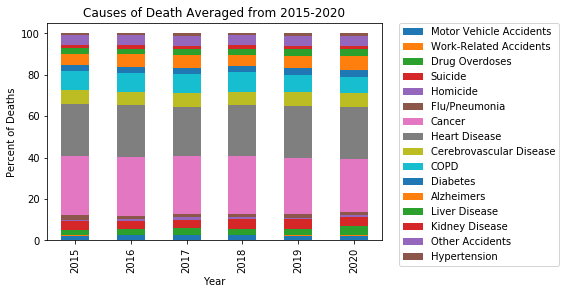

In [19]:
# Stacked Bar Plot by Percentage of Type of Death for Each Year
labeledTimeCause2 = dict()
for i, key in enumerate(timeCause2):
    labeledTimeCause2[titles2[i]] = timeCause2[key]
StructGraph3 = pd.DataFrame.from_dict(labeledTimeCause2, orient='index', columns=['2015', '2016', '2017', '2018', '2019', '2020'])
StructGraph3 = StructGraph3.transpose()
StructGraph3.insert(loc = 5, column = 'Flu/Pneumonia', value = StructGraph3['Flu'] + StructGraph3['Pneumonia'])
StructGraph3 = StructGraph3.drop(['Flu', 'Pneumonia'], 1)
StructGraph3 = StructGraph3.div(StructGraph3.sum(axis=1) / 100, axis=0)
axis = StructGraph3[StructGraph3.columns].plot(kind="bar", stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Causes of Death Averaged from 2015-2020')
plt.xlabel('Year')
plt.ylabel('Percent of Deaths')
fig = axis.get_figure()

In [20]:
# Creation of a dictionary for the pooled deaths with the baseline years in one year and 2020 as the other year
pooledDeathTwoY = dict()
for i, key in enumerate(pooledDeathsTime):
    temp = [0] * 2
    avg = 0
    for el in pooledDeathsTime[key][0:len(pooledDeathsTime[key]) - 1]:
        avg += el
    temp[0] = avg / (len(pooledDeathsTime[key]) - 1)
    temp[1] = pooledDeathsTime[key][-1]
    pooledDeathTwoY[key] = temp

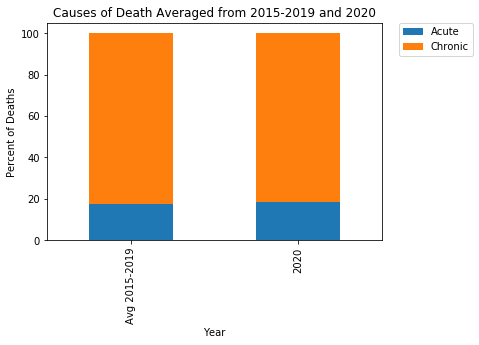

In [21]:
# Plot of Acute and Chronic Deaths (Baseline vs 2020)
StructGraph2 = pd.DataFrame.from_dict(pooledDeathTwoY, orient='index', columns=['Avg 2015-2019', '2020'])
StructGraph2 = StructGraph2.transpose()
StructGraph2 = StructGraph2.div(StructGraph2.sum(axis=1) / 100, axis=0)
axis = StructGraph2[StructGraph2.columns].plot(kind="bar", stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Causes of Death Averaged from 2015-2019 and 2020')
plt.xlabel('Year')
plt.ylabel('Percent of Deaths')
fig = axis.get_figure()

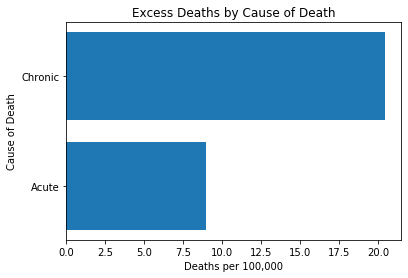

In [22]:
# Plot of Acute and Chronic Deaths
pooledDeaths = {'Acute': 0, 'Chronic': 0}
for i, key in enumerate(sumExcessDeathCause):
    pooledDeaths [typeCause[i]] += sumExcessDeathCause[key]

pooledDeathsPop = dict()
for key in pooledDeaths:
    pooledDeathsPop [key] = pooledDeaths[key] / sum(pop)
    
y_pos = np.arange(len(pooledDeathsPop))
plt.barh(y_pos, list(pooledDeathsPop.values()), align='center')
plt.yticks(y_pos, list(pooledDeathsPop.keys()))
plt.xlabel('Deaths per 100,000')
plt.ylabel('Cause of Death')
plt.title('Excess Deaths by Cause of Death')
plt.show()

# Sex, Race, Ethnicity Results Non-Age Adjusted

In [23]:
# 2020 deaths by race, sex, and ethnicity
NIHCOVID2020 = dict()
NIHAll2020 = dict()
raw = pd.read_csv('csv_data/co_deaths_weeksum_20.csv')
for race in raceList:
    for hisp in hispList:
        for sex in ['Male', 'Female']:
            raw = raw[raw.dwk != 'Annual total']
            raw['dwk'] = raw['dwk'].astype(int)
            raw = raw[raw['dwk'].isin(list(range(9, 37)))]
            alter = raw[raw['racegr'] == race]
            alter2 = alter[alter['hispgr'] == hisp]
            alter3 = alter2[alter2['sexgr'] == sex]
            alter4 = alter3[alter3['agegr'] == 'All Ages']
            alter5 = sum(alter4.groupby('fips')['d'].sum().values.astype(int)[1:])
            alter6 = sum(alter4.groupby('fips')['covid'].sum().values.astype(int)[1:])
            NIHCOVID2020 [(race, hisp, sex)] = alter6
            NIHAll2020 [(race, hisp, sex)] = alter5

/Users/JayChandra/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/JayChandra/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [24]:
# 2015-2019 deaths by race, sex, and ethnicity
years = ['15', '16', '17', '18', '19']
NIHCOVID = dict()
NIHAll = dict()
NIHAllArray = []
first = True
for year in years:
    path = 'csv_data/co_deaths_weeksum_' + year + '.csv'
    raw = pd.read_csv(path)
    NIHAll2 = dict()
    for race in raceList:
        for hisp in hispList:
            for sex in ['Male', 'Female']:
                raw = raw[raw.dwk != 'Annual total']
                raw['dwk'] = raw['dwk'].astype(int)
                raw = raw[raw['dwk'].isin(list(range(9, 37)))]
                alter = raw[raw['racegr'] == race]
                alter2 = alter[alter['hispgr'] == hisp]
                alter3 = alter2[alter2['sexgr'] == sex]
                alter4 = alter3[alter3['agegr'] == 'All Ages']
                alter5 = sum(alter4.groupby('fips')['d'].sum().values.astype(int)[1:])
                alter6 = sum(alter4.groupby('fips')['covid'].sum().values.astype(int)[1:])
                if first:
                    NIHCOVID [(race, hisp, sex)] = alter6
                    NIHAll [(race, hisp, sex)] = alter5
                else:
                    NIHCOVID [(race, hisp, sex)] += alter6
                    NIHAll [(race, hisp, sex)] += alter5
                    
                NIHAll2 [(race, hisp, sex)] = alter5.copy()          
    NIHAllArray.append(NIHAll2.copy())
    first = False

# Baseline Calculation by Averaging 2015-2019 deaths
for key in NIHAll:
    NIHAll[key] = NIHAll[key]/len(years)
    NIHCOVID[key] = NIHCOVID[key]/len(years)
    
NIHAllArray.append(NIHAll2020)

In [25]:
#Pop for Race, Sex, Ethnicity
NIHPop = dict()
path = 'csv_data/county-raceEstimate_data.csv'
rawPop = pd.read_csv(path, error_bad_lines=False)
rawPop['COUNT'] = np.array([p.replace(',', '') for p in rawPop['COUNT']])
raceListPop = list(set(rawPop['RACE']))
hispanicListPop = list(set(rawPop['ETHNICITY']))
raceListPop.sort()
hispanicListPop.sort()
for race in raceListPop:
    for hisp in hispanicListPop:
        for sex in ['M', 'F']:
            alter = rawPop[rawPop['RACE'] == race]
            alter2 = alter[alter['ETHNICITY'] == hisp]
            alter3 = alter2[alter2['SEX'] == sex]
            NIHPop [(race, hisp, sex)] = sum(alter3['COUNT'].values.astype(float))/100000

In [26]:
# Excess Death, COVID, Multiplier Calculation
excessDeathRace = dict()
COVIDRace = dict()
for key in NIHAll2020:
    excessDeathRace[key] = NIHAll2020[key] - NIHAll[key]
    COVIDRace[key] = NIHCOVID2020[key] - NIHCOVID[key]

# Population Adjustment- Need to rearrange NIHPopArr to match excess deaths dictionary
excessDeathRacePop = dict()
COVIDRacePop = dict()
NIHPopArr = np.array(list(NIHPop.values()))
for i, key in enumerate(NIHAll2020):
    excessDeathRacePop[key] = excessDeathRace[key] / NIHPopArr[i]
    COVIDRacePop[key] = COVIDRace[key] / NIHPopArr[i]
    
# 95% Confidence Interval for the baseline based on the deaths from 2015-2019
rangeT = []
lastYear = []
for key in NIHAll:
    tempRace = []
    for i in range(5):
        tempRace.append(NIHAllArray[i][key])
    lastYear.append(NIHAllArray[5][key])
        
    baselineInt = st.t.interval(0.95, len(tempRace)-1, loc= 1./ float(np.mean(tempRace)), 
                                scale=st.sem(tempRace) * (1./float(np.mean(tempRace)))**2)
    rangeT.append([NIHAllArray[5][key] * baselineInt[0], NIHAllArray[5][key] * baselineInt[1]])

errorT = []
for item in rangeT:
    errorT.append((item[1]-item[0])/2)

multiplierRace = dict()
for i, key in enumerate(NIHAll2020):
    mult = NIHAll2020[key] / NIHAll[key]
    multiplierRace[key] = [mult, errorT[i]]

# Rank the results for visualization
sorted_COVIDRacePop = sorted(COVIDRacePop.items(), key=lambda kv: kv[1])
dict_1 = dict() 
for key,value in sorted_COVIDRacePop: 
    dict_1.setdefault(key, value)
sorted_COVIDRacePop = dict_1.copy()


sorted_excessDeathRacePop = sorted(excessDeathRacePop.items(), key=lambda kv: kv[1])
dict_1 = dict() 
for key,value in sorted_excessDeathRacePop: 
    dict_1.setdefault(key, value)
sorted_excessDeathRacePop = dict_1.copy()

In [27]:
# Exports an excel file with the population data
popTable = dict()
for key in NIHPop:
    popTable[key] = int(NIHPop[key] * 100000)
    
# Creates a Dataframe with Population Adjusted COVID Deaths
Struct = pd.DataFrame.from_dict(popTable, orient='index', columns=['2017 Population'])

writer = pd.ExcelWriter('Race_Eth_Sex_Pop_COVID.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Struct.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

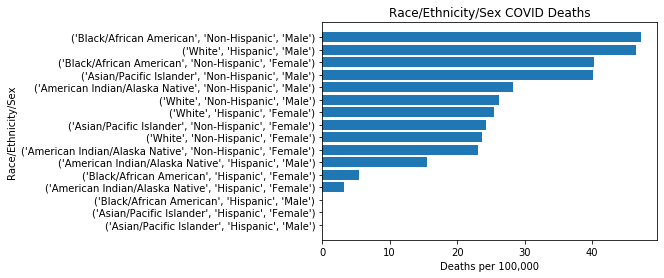

In [28]:
# Plot of COVID Deaths Population Normalized
y_pos = np.arange(len(sorted_COVIDRacePop))
plt.barh(y_pos, list(sorted_COVIDRacePop.values()), align='center')
plt.yticks(y_pos, list(sorted_COVIDRacePop.keys()))
plt.xlabel('Deaths per 100,000')
plt.ylabel('Race/Ethnicity/Sex')
plt.title('Race/Ethnicity/Sex COVID Deaths')
plt.show()

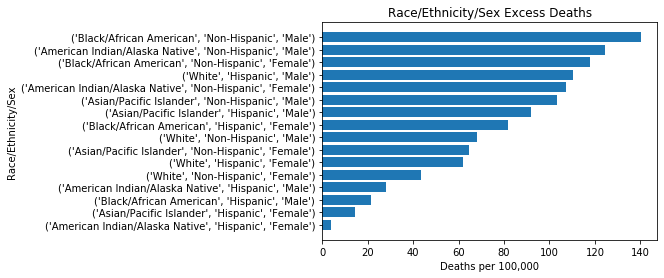

In [29]:
# Plot of Excess Deaths Population Normalized
y_pos = np.arange(len(sorted_excessDeathRacePop))
plt.barh(y_pos, list(sorted_excessDeathRacePop.values()), align='center')
plt.yticks(y_pos, list(sorted_excessDeathRacePop.keys()))
plt.xlabel('Deaths per 100,000')
plt.ylabel('Race/Ethnicity/Sex')
plt.title('Race/Ethnicity/Sex Excess Deaths')
plt.show()

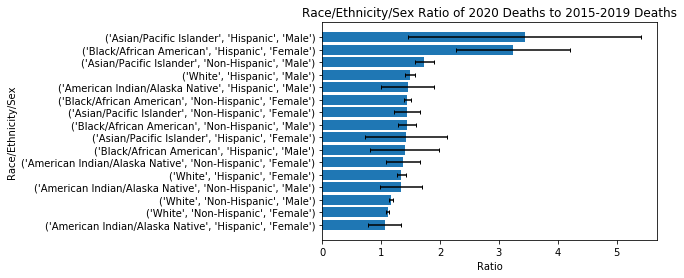

In [30]:
# Plot of Ratio of Deaths 
sorted_multipliers = sorted(multiplierRace.items(), key=lambda kv: kv[1][0])
dict_1 = dict() 
for key,value in sorted_multipliers: 
    dict_1.setdefault(key, value)
sorted_multipliers = dict_1.copy()

y_pos = np.arange(len(sorted_multipliers))
plt.barh(y_pos, [i[0] for i in list(sorted_multipliers.values())], align='center')
plt.errorbar([i[0] for i in list(sorted_multipliers.values())], y_pos,
             xerr = np.array([i[1] for i in list(sorted_multipliers.values())]).T, ls='none', 
             ecolor = 'black', capsize = 2)
plt.yticks(y_pos, list(sorted_multipliers.keys()))
plt.xlabel('Ratio')
plt.ylabel('Race/Ethnicity/Sex')
plt.title('Race/Ethnicity/Sex Ratio of 2020 Deaths to 2015-2019 Deaths')
plt.show()

In [31]:
# Creates a Dataframe with Ratios
Struct = pd.DataFrame.from_dict(sorted_multipliers, orient='index', columns=['Multiplier', 'Error'])

writer = pd.ExcelWriter('Race_Eth_Sex_Multipliers.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Struct.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [32]:
# Aggregation of Excess Death Data into Races rather than Race, Eth, and Sex
raceList = ['Asian/Pacific Islander', 'American Indian/Alaska Native', 'Black/African American', 'White']
raceDeathPop = dict()
raceCOVIDPop = dict()
racePop = dict()
raceListCop = raceList.copy()
raceDeath2020 = dict()
raceDeathBase = dict()
multiplierSmallRace = dict()
for race in raceList:
    for i, key in enumerate(excessDeathRace):
        if key[0] == race and key[0] in raceListCop:
            raceDeathPop[key[0]] = excessDeathRace[key].copy()
            racePop[key[0]] = NIHPopArr[i].copy()
            raceCOVIDPop[key[0]] = COVIDRace[key].copy()
            raceDeath2020[key[0]] = NIHAll2020[key].copy()
            raceDeathBase[key[0]] = NIHAll[key].copy()
            raceListCop.remove(key[0])
        elif key[0] == race:
            raceDeathPop[key[0]] += excessDeathRace[key].copy()
            racePop[key[0]] += NIHPopArr[i].copy()
            raceCOVIDPop[key[0]] += COVIDRace[key].copy()
            raceDeath2020[key[0]] += NIHAll2020[key].copy()
            raceDeathBase[key[0]] += NIHAll[key].copy()

            
for key in raceDeathPop:
    raceDeathPop [key] = raceDeathPop [key] / racePop [key]
    raceCOVIDPop [key] = raceCOVIDPop [key] / racePop [key]
    multiplierSmallRace[key] = raceDeath2020[key]/raceDeathBase[key]

In [33]:
# Aggregation of Excess Death Data into Sex and Ethnicity rather than Race, Eth, Sex
sexEthDeathPop = dict()
sexEthCOVIDPop = dict()
sexEthPop = dict()
sexEthDeath2020 = dict()
sexEthDeathBase = dict()
multiplierSexEth = dict()

for i, key in enumerate(excessDeathRace):
    if (key[1], key[2]) not in sexEthDeathPop:
        sexEthDeathPop[(key[1], key[2])] = excessDeathRace[key].copy()
        sexEthPop[(key[1], key[2])] = NIHPopArr[i].copy()
        sexEthCOVIDPop[(key[1], key[2])] = COVIDRace[key].copy()
        sexEthDeath2020[(key[1], key[2])] = NIHAll2020[key].copy()
        sexEthDeathBase[(key[1], key[2])] = NIHAll[key].copy()
    else:
        sexEthDeathPop[(key[1], key[2])] += excessDeathRace[key].copy()
        sexEthPop[(key[1], key[2])] += NIHPopArr[i].copy()
        sexEthCOVIDPop[(key[1], key[2])] += COVIDRace[key].copy()
        sexEthDeath2020[(key[1], key[2])] += NIHAll2020[key].copy()
        sexEthDeathBase[(key[1], key[2])] += NIHAll[key].copy()

for key in sexEthDeathPop:
    sexEthDeathPop [key] = sexEthDeathPop [key] / sexEthPop [key]
    sexEthCOVIDPop [key] = sexEthCOVIDPop [key] / sexEthPop [key]
    multiplierSexEth[key] = sexEthDeath2020[key]/sexEthDeathBase[key]

In [34]:
# Grouping into white and non-white (minority group)
minorDeath2020 = dict()
minorDeathBase = dict()
multiplierMinor = dict()

for i, key in enumerate(excessDeathRace):
    if key[0] == 'White':
        minorDeath2020[key] = NIHAll2020[key].copy()
        minorDeathBase[key] = NIHAll[key].copy()
    
    else:
        if (('minor', key[1], key[2])) not in minorDeath2020:
            minorDeath2020[('minor', key[1], key[2])] = NIHAll2020[key].copy()
            minorDeathBase[('minor', key[1], key[2])] = NIHAll[key].copy()
        else:
            minorDeath2020[('minor', key[1], key[2])] += NIHAll2020[key].copy()
            minorDeathBase[('minor', key[1], key[2])] += NIHAll[key].copy()

for key in minorDeath2020:
    multiplierMinor[key] = minorDeath2020[key]/minorDeathBase[key]

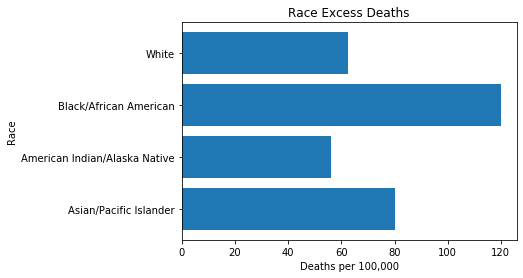

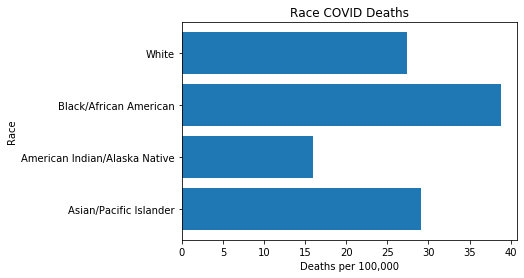

In [35]:
# Visualization of Race COVID and Excess Deaths
y_pos = np.arange(len(raceDeathPop))
plt.barh(y_pos, list(raceDeathPop.values()), align='center')
plt.yticks(y_pos, list(raceDeathPop.keys()))
plt.xlabel('Deaths per 100,000')
plt.ylabel('Race')
plt.title('Race Excess Deaths')
plt.show()

y_pos = np.arange(len(raceCOVIDPop))
plt.barh(y_pos, list(raceCOVIDPop.values()), align='center')
plt.yticks(y_pos, list(raceCOVIDPop.keys()))
plt.xlabel('Deaths per 100,000')
plt.ylabel('Race')
plt.title('Race COVID Deaths')
plt.show()

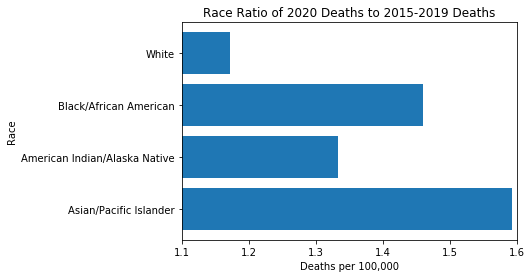

In [36]:
# Ratio of Deaths by Race
y_pos = np.arange(len(multiplierSmallRace))
plt.barh(y_pos, list(multiplierSmallRace.values()), align='center')
plt.yticks(y_pos, list(multiplierSmallRace.keys()))
plt.xlim((1.1, 1.6))
plt.xlabel('Deaths per 100,000')
plt.ylabel('Race')
plt.title('Race Ratio of 2020 Deaths to 2015-2019 Deaths')
plt.show()

# Age Adjusted Sex, Race, Ethnicity Results

In [37]:
# 2020 Sex, Race, Ethnicity Results by Age
NIHCOVID2020 = dict()
NIHAll2020 = dict()
raw = pd.read_csv('csv_data/co_deaths_weeksum_20.csv')
raw = raw[raw['fips'] == 8000]
for race in raceList:
    for hisp in hispList:
        for sex in ['Male', 'Female']:
            raw = raw[raw.dwk != 'Annual total']
            raw['dwk'] = raw['dwk'].astype(int)
            raw = raw[raw['dwk'].isin(list(range(9, 37)))]
            alter = raw[raw['racegr'] == race]
            alter2 = alter[alter['hispgr'] == hisp]
            alter3 = alter2[alter2['sexgr'] == sex]
            alter4 = alter3.groupby('agegr')['d'].sum().values.astype(int)[0:11]
            # Reordering of ages in the array
            temp = alter4[6]
            tempArr = np.delete(alter4, 6)
            alter4 = np.insert(tempArr, 2, temp)
            alter5 = alter3.groupby('agegr')['covid'].sum().values.astype(int)[0:11]
            # Reordering of ages in the array
            temp = alter5[6]
            tempArr = np.delete(alter5, 6)
            alter5 = np.insert(tempArr, 2, temp)
            NIHCOVID2020 [(race, hisp, sex)] = alter5
            NIHAll2020 [(race, hisp, sex)] = alter4

In [38]:
NIHAllArray = []
NIHCOVID = dict()
NIHAll = dict()
first = True
for year in years:
    path = 'csv_data/co_deaths_weeksum_' + year + '.csv'
    raw = pd.read_csv(path)
    raw = raw[raw['fips'] == 8000]
    NIHAll2 = dict()
    for race in raceList:
        for hisp in hispList:
            for sex in ['Male', 'Female']:
                raw = raw[raw.dwk != 'Annual total']
                raw['dwk'] = raw['dwk'].astype(int)
                raw = raw[raw['dwk'].isin(list(range(9, 37)))]
                alter = raw[raw['racegr'] == race]
                alter2 = alter[alter['hispgr'] == hisp]
                alter3 = alter2[alter2['sexgr'] == sex]
                alter4 = alter3.groupby('agegr')['d'].sum().values.astype(int)[0:11]
                # Reordering of ages in the array
                temp = alter4[6]
                tempArr = np.delete(alter4, 6)
                alter4 = np.insert(tempArr, 2, temp)
                alter5 = alter3.groupby('agegr')['covid'].sum().values.astype(int)[0:11]
                # Reordering of ages in the array
                temp = alter5[6]
                tempArr = np.delete(alter5, 6)
                alter5 = np.insert(tempArr, 2, temp)
                if first:
                    NIHCOVID [(race, hisp, sex)] = alter5
                    NIHAll [(race, hisp, sex)] = alter4
                else:
                    NIHCOVID [(race, hisp, sex)] += alter5
                    NIHAll [(race, hisp, sex)] += alter4
                    
                NIHAll2 [(race, hisp, sex)] = alter4.copy()          
    NIHAllArray.append(NIHAll2.copy())
    first = False

# Baseline Calculation by Averaging 2015-2019
for key in NIHAll:
    NIHAll[key] = NIHAll[key]/len(years)
    NIHCOVID[key] = NIHCOVID[key]/len(years)
    
NIHAllArray.append(NIHAll2020)

In [39]:
# Population for each age group in the each race, ethnicity, and sex combination
ages = [1, 4] + 9 * [10]
NIHPop = dict()
path = 'csv_data/county-raceEstimate_data2.csv'
rawPop = pd.read_csv(path, error_bad_lines=False)
rawPop['COUNT'] = np.array([p.replace(',', '') for p in rawPop['COUNT']])
raceListPop = list(set(rawPop['RACE']))
hispanicListPop = list(set(rawPop['ETHNICITY']))
raceListPop.sort()
hispanicListPop.sort()
for race in raceListPop:
    for hisp in hispanicListPop:
        for sex in ['M', 'F']:
            alter = rawPop[rawPop['RACE'] == race]
            alter2 = alter[alter['ETHNICITY'] == hisp]
            alter3 = alter2[alter2['SEX'] == sex]
            alter4 = []
            startA = 0
            for diff in ages:
                alter4.append(sum(alter3[alter3['AGE'].isin(list(range(startA, startA + diff)))]['COUNT'].values.astype(int)))
                startA += diff
            NIHPop [(race, hisp, sex)] = np.array(alter4)/100000

In [40]:
# Median Ages of Specific Ethnicity or Race or Sex
race = 'Black'
medList = []
for i, j in rawPop.iterrows():
    if j['RACE'] == race:
        medList = medList + ([j['AGE']] * int(j['COUNT']))
        
# statistics.median(medList)

In [41]:
# Calculation of COVID and Excess Deaths
excessDeathRace = dict()
COVIDRace = dict()
multiplierRace = dict()
for key in NIHAll2020:
    excessDeathRace[key] = NIHAll2020[key]-NIHAll[key]
    COVIDRace[key] = NIHCOVID2020[key] - NIHCOVID[key]
    
excessDeathRacePop = dict()
COVIDRacePop = dict()
# Rearranging Population to match Excess Death Dicts
NIHPopArr = np.array(list(NIHPop.values()))
NIHPopArr = list(NIHPop.values())
tempPop = NIHPopArr[4:8]
del NIHPopArr[4:8]
NIHPopArr = tempPop + NIHPopArr
for i, key in enumerate(NIHAll2020):
    excessDeathRacePop[key] = np.array(excessDeathRace[key])/np.array(NIHPopArr[i])
    COVIDRacePop[key] = np.array(COVIDRace[key])/np.array(NIHPopArr[i])

NIHAllArrayPop = []
for i in range(len(NIHAllArray)):
    tempRace = dict()
    for j, key in enumerate(NIHAll2020):
        tempRace[key] = np.array(NIHAllArray[i][key])/np.array(NIHPopArr[j])
    NIHAllArrayPop.append(tempRace)

In [42]:
# Age Adjusted Rate Calculation
path = 'csv_data/Age_Weights.csv'
rawPop = pd.read_csv(path, error_bad_lines=False)
weights = rawPop['Weights'].values.astype(float)
for i, key in enumerate(excessDeathRacePop):
    excessDeathRacePop[key] = sum(excessDeathRacePop[key] * weights)
    COVIDRacePop[key] = sum(COVIDRacePop[key] * weights)
    
NIHAllArrayPopWeight = []
for i in range(len(NIHAllArrayPop)):
    tempRace = dict()
    for key in NIHAll2020:
        tempRace[key] = sum(np.array(NIHAllArrayPop[i][key]) * weights)
    NIHAllArrayPopWeight.append(tempRace)
    
    
# 95% Confidence Interval for the baseline based on the deaths from 2015-2019
rangeT = []
lastYear = []
for key in NIHAllArrayPopWeight[0]:
    tempRace = []
    for i in range(5):
        tempRace.append(NIHAllArrayPopWeight[i][key])
    lastYear.append(NIHAllArrayPopWeight[5][key])
        
    baselineInt = st.t.interval(0.95, len(tempRace)-1, loc=np.mean(tempRace), scale=st.sem(tempRace))
    rangeT.append(baselineInt)

errorT = []
for item in rangeT:
    errorT.append(item[1]-item[0])
errorT = np.array(errorT)/2

# Sort for Visualization
sorted_COVIDRacePop = sorted(COVIDRacePop.items(), key=lambda kv: kv[1])
dict_1 = dict() 
for key,value in sorted_COVIDRacePop: 
    dict_1.setdefault(key, value)
sorted_COVIDRacePop = dict_1.copy()


sorted_excessDeathRacePop = sorted(excessDeathRacePop.items(), key=lambda kv: kv[1])
dict_1 = dict() 
for key,value in sorted_excessDeathRacePop: 
    dict_1.setdefault(key, value)
sorted_excessDeathRacePop = dict_1.copy()

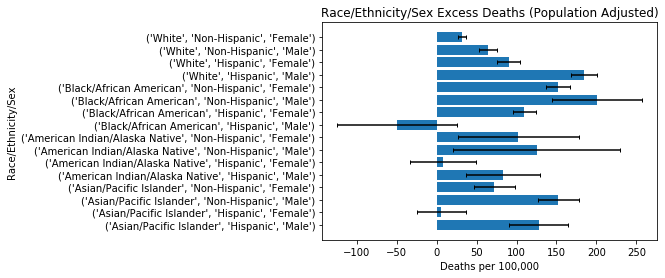

In [43]:
y_pos = np.arange(len(excessDeathRacePop))
plt.barh(y_pos, list(excessDeathRacePop.values()), align='center')
plt.yticks(y_pos, list(excessDeathRacePop.keys()))
plt.errorbar(excessDeathRacePop.values(), y_pos,
             xerr = errorT, ls='none', ecolor = 'black', capsize = 2)
plt.xlabel('Deaths per 100,000')
plt.ylabel('Race/Ethnicity/Sex')
plt.title('Race/Ethnicity/Sex Excess Deaths (Population Adjusted)')
plt.show()

In [44]:
# Creates a Dataframe with Population Adjusted Excess Deaths
Struct = pd.DataFrame.from_dict(excessDeathRacePop, orient='index', columns=['Excess Deaths Pop Adj'])
Struct.insert(1, column = 'Error', value = errorT)

writer = pd.ExcelWriter('Race_Eth_Sex_Excess_Error.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Struct.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

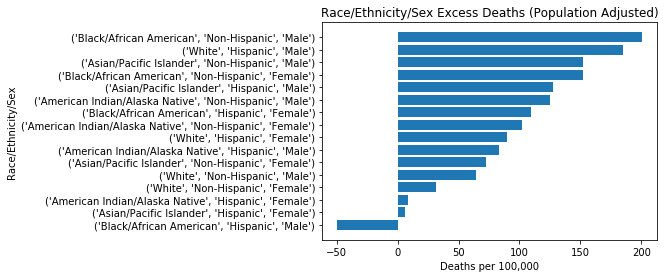

In [45]:
y_pos = np.arange(len(sorted_excessDeathRacePop))
plt.barh(y_pos, list(sorted_excessDeathRacePop.values()), align='center')
plt.yticks(y_pos, list(sorted_excessDeathRacePop.keys()))
plt.xlabel('Deaths per 100,000')
plt.ylabel('Race/Ethnicity/Sex')
plt.title('Race/Ethnicity/Sex Excess Deaths (Population Adjusted)')
plt.show()

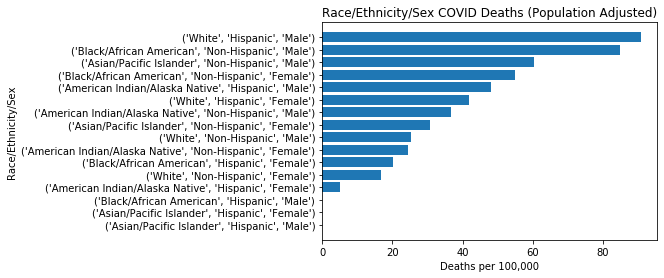

In [46]:
y_pos = np.arange(len(sorted_COVIDRacePop))
plt.barh(y_pos, list(sorted_COVIDRacePop.values()), align='center')
plt.yticks(y_pos, list(sorted_COVIDRacePop.keys()))
plt.xlabel('Deaths per 100,000')
plt.ylabel('Race/Ethnicity/Sex')
plt.title('Race/Ethnicity/Sex COVID Deaths (Population Adjusted)')
plt.show()

In [47]:
# Aggregation to four races
raceList = ['Asian/Pacific Islander', 'American Indian/Alaska Native', 'Black/African American', 'White']
raceDeathPop = dict()
raceCOVIDPop = dict()
racePop = dict()
raceListCop = raceList.copy()
for race in raceList:
    for i, key in enumerate(excessDeathRace):
        if key[0] == race and key[0] in raceListCop:
            raceDeathPop[key[0]] = excessDeathRace[key].copy()
            racePop[key[0]] = NIHPopArr[i].copy()
            raceCOVIDPop[key[0]] = COVIDRace[key].copy()
            raceListCop.remove(key[0])
        elif key[0] == race:
            raceDeathPop[key[0]] += excessDeathRace[key].copy()
            racePop[key[0]] += NIHPopArr[i].copy()
            raceCOVIDPop[key[0]] += COVIDRace[key].copy()
                
for key in raceDeathPop:
    raceDeathPop [key] = raceDeathPop [key] / racePop [key]
    raceCOVIDPop [key] = raceCOVIDPop [key] / racePop [key]

In [48]:
# Age Adjusted
for i, key in enumerate(raceDeathPop):
    raceDeathPop[key] = sum(raceDeathPop[key] * weights)
    raceCOVIDPop[key] = sum(raceCOVIDPop[key] * weights)

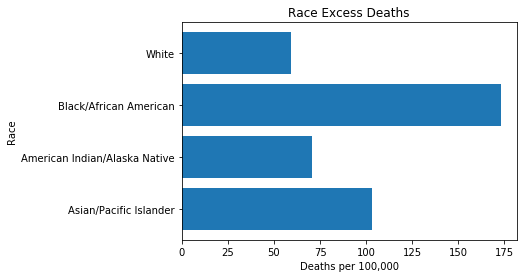

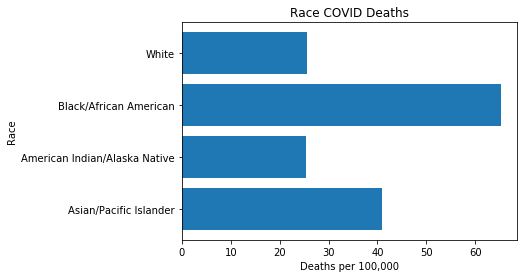

In [49]:
# Plot of Age Adjusted Excess Deaths and COVID Deaths
y_pos = np.arange(len(raceDeathPop))
plt.barh(y_pos, list(raceDeathPop.values()), align='center')
plt.yticks(y_pos, list(raceDeathPop.keys()))
plt.xlabel('Deaths per 100,000')
plt.ylabel('Race')
plt.title('Race Excess Deaths')
plt.show()

y_pos = np.arange(len(raceCOVIDPop))
plt.barh(y_pos, list(raceCOVIDPop.values()), align='center')
plt.yticks(y_pos, list(raceCOVIDPop.keys()))
plt.xlabel('Deaths per 100,000')
plt.ylabel('Race')
plt.title('Race COVID Deaths')
plt.show()

In [50]:
# By Sex and Ethnicity (Without Race)
sexEthDeathPop = dict()
sexEthCOVIDPop = dict()
sexEthPop = dict()
for i, key in enumerate(excessDeathRace):
    if (key[1], key[2]) not in sexEthDeathPop:
        sexEthDeathPop[(key[1], key[2])] = excessDeathRace[key].copy()
        sexEthPop[(key[1], key[2])] = NIHPopArr[i].copy()
        sexEthCOVIDPop[(key[1], key[2])] = COVIDRace[key].copy()
    else:
        sexEthDeathPop[(key[1], key[2])] += excessDeathRace[key].copy()
        sexEthPop[(key[1], key[2])] += NIHPopArr[i].copy()
        sexEthCOVIDPop[(key[1], key[2])] += COVIDRace[key].copy()

for key in sexEthDeathPop:
    sexEthDeathPop [key] = sexEthDeathPop [key] / sexEthPop [key]
    sexEthCOVIDPop [key] = sexEthCOVIDPop [key] / sexEthPop [key]

In [51]:
# Age Adjustment
for i, key in enumerate(sexEthDeathPop):
    sexEthDeathPop[key] = sum(sexEthDeathPop[key] * weights)
    sexEthCOVIDPop[key] = sum(sexEthCOVIDPop[key] * weights)

In [52]:
# Creates a Dataframe with Population Adjusted Excess Deaths
Struct = pd.DataFrame.from_dict(sorted_excessDeathRacePop, orient='index', columns=['Excess Deaths Pop Adj'])

writer = pd.ExcelWriter('Race_Eth_Sex_Excess.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Struct.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [53]:
# Creates a Dataframe with Population Adjusted COVID Deaths
Struct = pd.DataFrame.from_dict(sorted_COVIDRacePop, orient='index', columns=['COVID Pop Adj'])

writer = pd.ExcelWriter('Race_Eth_Sex_COVID.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Struct.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()